In [ ]:
import geopandas as gpd
import rasterio
import xarray
import leafmap
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
print("All libraries imported successfully!")


All libraries imported successfully!


In [3]:
m = leafmap.Map(center=[40, -100], zoom=4, height="500px")

m.add_basemap("OpenTopoMap")
m.add_basemap("USGS.Imagery")

m

Map(center=[40, -100], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [5]:
#create a GeoPandas GeoDataFrame
data = {
    "City": ["Tokyo", "New York", "London", "Paris"],
    "Latitude": [35.6895, 40.7128, 51.5074, 48.8566],
    "Longitude": [139.6917, -74.0060, -0.1278, 2.3522]
}
#firstly we create the regular pandas DataFrame
df = pd.DataFrame(data)
#then we convert it to a GeoDataFrame by creating Point geometries from coordinates lat and lon pairs
gdf = gpd.GeoDataFrame(df,geometry=gpd.points_from_xy(df.Longitude,df.Latitude))
gdf

,City,Latitude,Longitude,geometry
0,Tokyo,35.6895,139.6917,POINT (139.6917 35.6895)
1,New York,40.7128,-74.0060,POINT (-74.006 40.7128)
2,London,51.5074,-0.1278,POINT (-0.1278 51.5074)
3,Paris,48.8566,2.3522,POINT (2.3522 48.8566)


In [6]:
#Reading a GeoJSON File
url = "https://github.com/opengeos/datasets/releases/download/vector/nybb.geojson"
gdf = gpd.read_file(url)
gdf.head()

ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/../libgdal.so.36)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/../libgdal.so.36)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/../libgdal.so.36)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/../libgdal.so.36)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/gdal_netCDF.so)
ERROR 1: /lib/x86_64-linux-gnu/libstdc++.so.6: version `CXXABI_1.3.15' not found (required by /app/workspace/miniconda3/envs/gispro/lib/gdalplugins/gdal_netCDF.so)


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227...."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940...."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278..."


In [ ]:
#writing geospatial data allows us to save work in different formats which provides flexibility
#for sharing data with different software systems
output_file = "nyc_boroughs.geojson"
gdf.to_file(output_file,driver= "GeoJSON")
print(f"GeoDataFrame has been writte nto {output_file}")


GeoDataFrame has been writte nto nyc_boroughs.geojson


In [10]:
#saving into different formats like Shapefile, the traditional GIS-format and GeoPackage, the modern, single-file format)
output_file = "nyc_boroughs.shp"
gdf.to_file(output_file)
print(f"GeoDataFram has been written tp {output_file}")

output_file = "nyc_boroughs.gpkg"
gdf.to_file(output_file,driver="GPKG")
print(f"GeoDataFrame has been written to {output_file} as a type 'GeoPackage'\n")

GeoDataFram has been written tp nyc_boroughs.shp
GeoDataFrame has been written to nyc_boroughs.gpkg as a type 'GeoPackage'



 <span style="font-size:20px"> Now we try understanding coordinate ueference uystems</span> 

In [12]:
print(f"Current CRS: {gdf.crs}")

#time to reproject to globally compatible WGS84
gdf_4326 = gdf.to_crs(epsg=4326)
print(f"Reporjected CRS: {gdf_4326.crs}")
gdf_4326.head()

Current CRS: EPSG:2263
Reporjected CRS: EPSG:4326


,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((-73.83668 40.59495, -73.83678 ..."
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((-73.86706 40.58209, -73.86769 ..."
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."


Neat, now we see how the geometry feature shows coordinates in degrees rader than feet whicch EPSG:2263 used to have

 <span style="font-size:20px">That's cool and all but we need this for creating meaningful area measurements:</span> 

In [18]:
gdf["area"] = gdf.area

gdf["area_km2"] = gdf["area"] / 1_000_000

gdf[["area","area_km2"]].sort_values("area_km2", ascending=False) #sort the boroughs by area_km2 in descending order
gdf.head()

,BoroCode,BoroName,Shape_Leng,Shape_Area,geometry,area,area_km2,Boundary,Centroid,boundary,centroid
0,5,Staten Island,330470.010332,1.623820e+09,"MULTIPOLYGON (((970217.022 145643.332, 970227....",1.623822e+09,1623.821997,"MULTILINESTRING ((970217.022 145643.332, 97022...",POINT (941639.45 150931.991),"MULTILINESTRING ((970217.022 145643.332, 97022...",POINT (941639.45 150931.991)
1,4,Queens,896344.047763,3.045213e+09,"MULTIPOLYGON (((1029606.077 156073.814, 102957...",3.045214e+09,3045.213694,"MULTILINESTRING ((1029606.077 156073.814, 1029...",POINT (1034578.078 197116.604),"MULTILINESTRING ((1029606.077 156073.814, 1029...",POINT (1034578.078 197116.604)
2,3,Brooklyn,741080.523166,1.937479e+09,"MULTIPOLYGON (((1021176.479 151374.797, 102100...",1.937478e+09,1937.478349,"MULTILINESTRING ((1021176.479 151374.797, 1021...",POINT (998769.115 174169.761),"MULTILINESTRING ((1021176.479 151374.797, 1021...",POINT (998769.115 174169.761)
3,1,Manhattan,359299.096471,6.364715e+08,"MULTIPOLYGON (((981219.056 188655.316, 980940....",6.364712e+08,636.471238,"MULTILINESTRING ((981219.056 188655.316, 98094...",POINT (993336.965 222451.437),"MULTILINESTRING ((981219.056 188655.316, 98094...",POINT (993336.965 222451.437)
4,2,Bronx,464392.991824,1.186925e+09,"MULTIPOLYGON (((1012821.806 229228.265, 101278...",1.186926e+09,1186.926294,"MULTILINESTRING ((1012821.806 229228.265, 1012...",POINT (1021174.79 249937.98),"MULTILINESTRING ((1012821.806 229228.265, 1012...",POINT (1021174.79 249937.98)


Let's extract some geometric features

In [15]:
gdf["boundary"] = gdf.boundary #extracts boundary lines from the polygons

gdf["centroid"] = gdf.centroid #calculates geometric centers

#display the features
gdf[["boundary", "centroid"]].head()

,boundary,centroid
0,"MULTILINESTRING ((970217.022 145643.332, 97022...",POINT (941639.45 150931.991)
1,"MULTILINESTRING ((1029606.077 156073.814, 1029...",POINT (1034578.078 197116.604)
2,"MULTILINESTRING ((1021176.479 151374.797, 1021...",POINT (998769.115 174169.761)
3,"MULTILINESTRING ((981219.056 188655.316, 98094...",POINT (993336.965 222451.437)
4,"MULTILINESTRING ((1012821.806 229228.265, 1012...",POINT (1021174.79 249937.98)


In [25]:
# Check column names and values
print("columns:", list(gdf.columns))
print("unique BoroName values:", gdf['BoroName'].unique())

# Normalize BoroName for matching
gdf['boro_clean'] = gdf['BoroName'].astype(str).str.strip().str.lower()

# Ensure we have a CRS and use a metric projection for distance (EPSG:3857)
if gdf.crs is None:
    raise RuntimeError("gdf.crs is None — set a CRS before distance calculations")
if gdf.crs.is_geographic:
    gdf = gdf.to_crs(epsg=3857)

# Create centroids in the projected CRS
gdf['centroid'] = gdf.geometry.centroid

# Create boolean mask and check it
mask = gdf['boro_clean'] == 'manhattan'
if not mask.any():
    raise KeyError(f"No row matched 'manhattan'. Available: {gdf['boro_clean'].unique()}")

# Get Manhattan centroid and compute distances (meters -> kilometers)
manhattan_centroid = gdf.loc[mask, 'centroid'].iloc[0]
gdf['distance_to_manhattan_m'] = gdf['centroid'].distance(manhattan_centroid)
gdf['distance_to_manhattan_km'] = gdf['distance_to_manhattan_m'] / 1000

# Show results
gdf[['BoroName', 'distance_to_manhattan_km']].sort_values('distance_to_manhattan_km')

columns: ['BoroCode', 'BoroName', 'Shape_Leng', 'Shape_Area', 'geometry', 'area', 'area_km2', 'Boundary', 'Centroid', 'boundary', 'centroid', 'distance_to_manhattan', 'distance_to_manhattan_km']
unique BoroName values: ['Staten Island' 'Queens' 'Brooklyn' 'Manhattan' 'Bronx']


,BoroName,distance_to_manhattan_km
3,Manhattan,0.000000
4,Bronx,39.121024
1,Queens,48.401272
2,Brooklyn,48.586299
0,Staten Island,88.247743


In [26]:
import matplotlib.pyplot as plt
# Set high resolution for better quality plots
plt.rcParams["figure.dpi"] = 150

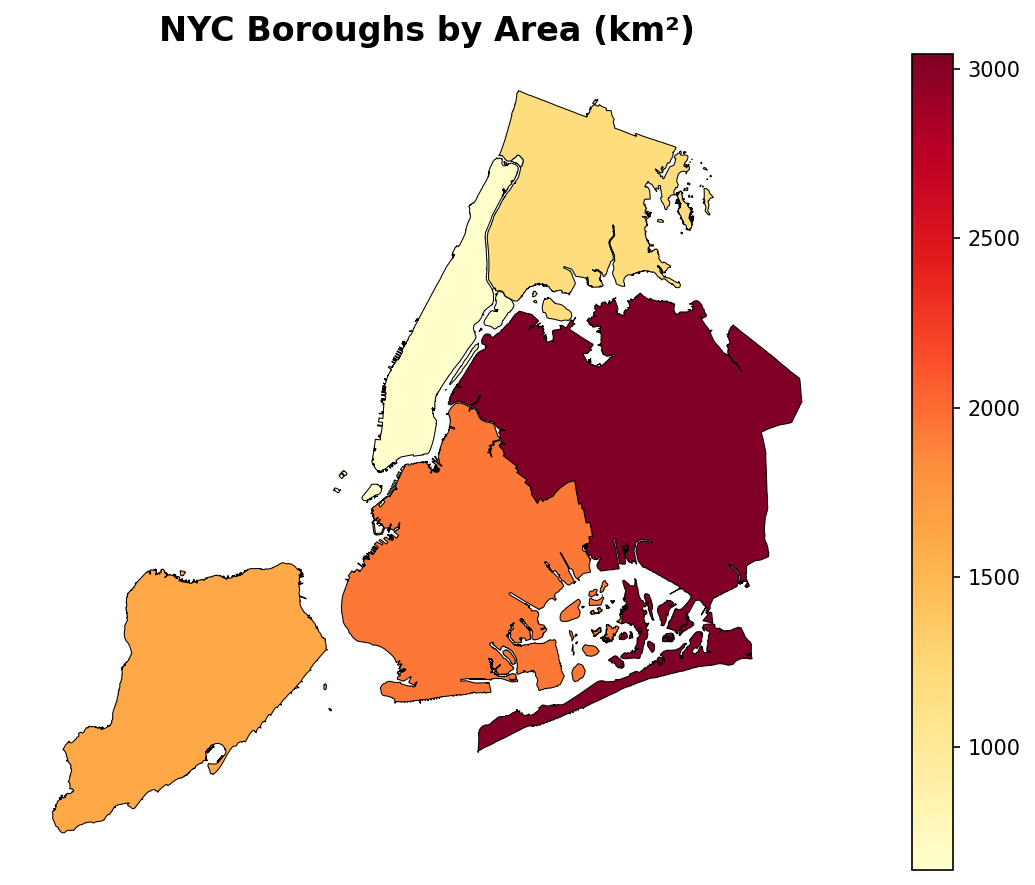

In [27]:
# Create a choropleth map showing borough areas
fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(
column="area_km2",
ax=ax,
legend=True,
cmap="YlOrRd", # Yellow-Orange-Red colormap
edgecolor="black",
linewidth=0.5,
)
plt.title("NYC Boroughs by Area (km²)", fontsize=16, fontweight="bold")
plt.axis("off") # Remove coordinate axes for cleaner appearance
plt.tight_layout()
plt.show()

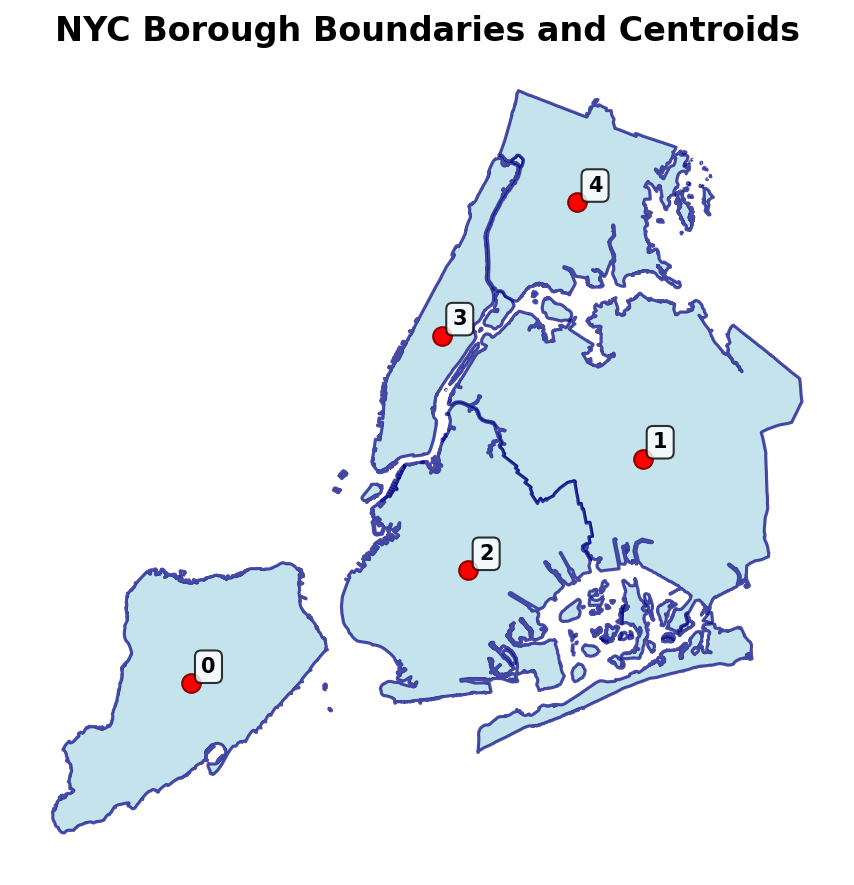

In [29]:
# Create a comprehensive map with multiple layers
fig, ax = plt.subplots(figsize=(10, 6))
# Plot borough boundaries as base layer
gdf["geometry"].plot(
    ax=ax, color="lightblue", edgecolor="navy", linewidth=1.5, alpha=0.7
)
# Add centroids as point layer
gdf["centroid"].plot(
    ax=ax, color="red", markersize=80, edgecolor="darkred", linewidth=1
)
# Add borough labels
for idx, row in gdf.iterrows():
    # Get centroid coordinates for label placement
    x = row.centroid.x
    y = row.centroid.y
    ax.annotate(
        idx,
        (x, y),
        xytext=(5, 5),
        textcoords="offset points",
        fontsize=10,
        fontweight="bold",
        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
    )
plt.title("NYC Borough Boundaries and Centroids", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

